In [1]:
import yaml
import pathlib
import pandas as pd
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn
import brokenaxes


import util

In [2]:
# Color style similar to ppt color scheme

plt.style.use('seaborn-colorblind')
# plt.rc('axes', prop_cycle=(plt.cycler('linestyle', ['-', '--', ':', '-.'])))

#Latex Default Font
plt.rc('font', family='serif') 
plt.rc('font', serif='Latin Modern Roman')
matplotlib.rcParams.update({'font.size': 16})

def make_hatches(ax, df):
    hatches = [h*len(df.index) for h in [['//'], ['--'], ['x'], ['\\'], ['||'], ['+'], ['o'], ['.']]]
    hatches = sum(hatches, [])

    if len(hatches) < len(ax.patches):
        print("Not enough hatches defined")
        
    for i,bar in enumerate(ax.patches):
        bar.set_hatch(hatches[i])
    ax.legend()

# Data Import and Cleaning

In [3]:
resBaseDir = pathlib.Path("results/latest")
thrResults = util.loadAllThroughput(resBaseDir / "throughputSuite")
sloResults = util.loadAllMlPerf(resBaseDir / "mlperfSuite", metric='completion_rate')
latResults = util.loadAllMlPerf(resBaseDir / "latDistribution", metric='p90')

microResults = util.loadMicro(resBaseDir / 'micro')

# Latency Distribution

In [4]:
def plotLatencies(lats, title="", log=True):
    cleanDfs = []
    for name, df in lats.items():
        cleanDfs.append(df.rename({'Actor': name + " Actor", 'KaaS': name + " KaaS"}, axis=1))
    pltDf = pd.concat(cleanDfs, axis=1).fillna(0) / 1000
#     plot = pltDf.plot(kind='bar', width=0.7, figsize=(10,4))
#     plot = pltDf.plot(kind='bar', width=0.7, figsize=(10,3), logy=log)
#     plot = pltDf.plot(kind='line', linewidth=2, logy=log)
    plot = seaborn.lineplot(data=pltDf, linewidth=3)

    plot.set_ylabel("90th Percentile Latency (s)")
    plot.set_xlabel("Number of Replicas")
    plot.tick_params(axis='x', labelrotation=0)
    make_hatches(plot, pltDf)
    
    plot.legend(bbox_to_anchor=(1,1))
    return plot

def plotNormalized(lats, log=False):
    plotDf = pd.DataFrame({workloadName: df.Actor / df.KaaS for workloadName, df in lats.items()})
#     plot = pltDf.plot(kind='bar', width=0.7, figsize=(10,4))
#     plot = plotDf.plot(kind='bar', width=0.7, figsize=(10,3), logy=log)
    plot = plotDf.plot(kind='line', linewidth=2, logy=log)
    plot.set_ylabel("90th Percentile Latency\n(ms)")
    plot.set_xlabel("Number of Replicas")
    plot.tick_params(axis='x', labelrotation=0)
    make_hatches(plot, plotDf)
    

    
# plotNormalized(latResults, log=False)

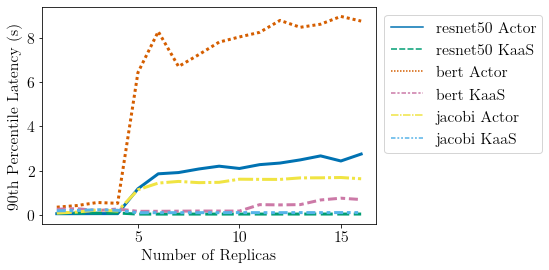

In [5]:
plot = plotLatencies(latResults)
# plot = plotLatencies({k: v for k, v in latResults.items() if k in ['resnet50', 'jacobi']}, log=True)
plot.figure.savefig("figs/latDistResults.png", dpi=300, bbox_inches='tight')

# CDFs

In [6]:
linestyles = [':', '--', '-.', (0, (3, 1, 1, 1, 1, 1)), '-']

def plotCDFs(names, arrs, title=''):
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(arrs, bins='auto', label=names, cumulative=True, density=True,
                               histtype='step', linewidth=2, linestyle='-')

    # Get rid of the zero value at the end (causes a vertical line)
    for idx, patch in enumerate(patches):
        patch[0].set_linestyle(linestyles[idx])
        patch[0].set_xy(patch[0].get_xy()[:-1])

    ax.set_xlabel("Latency (ms)")
    ax.legend(loc='lower right') 
    ax.set_title(title)
    

def loadCDFExps(configs):
    results = {}
    for model, mode, nReplica, independent in configs:
        expName = f"{model}_{mode}_{nReplica}"
        if independent:
            dirs = util.getRunDirs(resBaseDir / 'latIndependent', expNames=[expName])
        else:
            dirs = util.getRunDirs(resBaseDir / 'latDistribution', expNames=[expName])
            
        res, _ = util.loadOneMlPerf(dirs[expName])
        
        if mode == 'tvm':
            name = f"{model} Actor ({round(res['submission_rate'], 1)} qps)"
        else:
            name = f"{model} KaaS ({round(res['submission_rate'], 1)} qps)"
        
        results[name] = res['latencies']
        
    return results

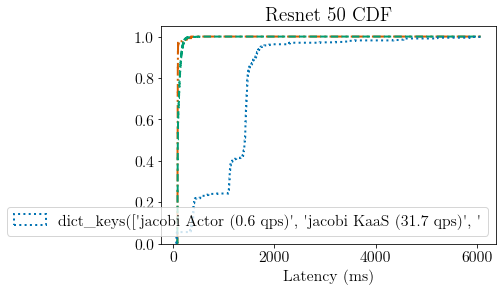

In [7]:
configs = [
    ('jacobi', 'tvm', 16, False),
    ('jacobi', 'kaas', 16, True),
    ('jacobi', 'kaas', 16, False)
]

cdfData = loadCDFExps(configs)
plotCDFs(cdfData.keys(), cdfData.values(), title="Resnet 50 CDF")
# plotCDFsSB(cdfData.keys(), cdfData.values(), title="Resnet 50 CDF")

# Online Experiment

In [8]:
def plotOnline(lats, title=""):
    cleanDfs = []
    for name, df in lats.items():
        cleanDfs.append(df.rename({'Actor': name + "(Actor)", 'KaaS': name + "(KaaS)"}, axis=1))
    pltDf = pd.concat(cleanDfs, axis=1).fillna(0)
    plot = pltDf.plot(kind='bar', width=0.7, figsize=(10,3))
    #plot = pltDf.plot(kind='line', linewidth=2)
    plot.set_ylabel("Aggregate QPS")
    plot.set_xlabel("Number of Replicas")
    plot.tick_params(axis='x', labelrotation=0)
    make_hatches(plot, pltDf)
    
    plot.legend(bbox_to_anchor=(1,1))
    return plot

In [9]:
# plot = plotOnline(sloResults)
# plot.figure.savefig("figs/onlineResults.png", dpi=300, bbox_inches='tight')

# Throughput Experiments

In [10]:
def plotThroughput(dfs, title=""):
    cleanDfs = []
    for name, wlDf in dfs.items():
        cleanDfs.append(wlDf.rename({"KaaS": f"{name} KaaS", "Actor": f"{name} Actor"}, axis=1))
    pltDf = pd.concat(cleanDfs)
    plot = seaborn.lineplot(data=pltDf, linewidth=3)
    plot.set_ylabel("Aggregate QPS")
    plot.set_xlabel("Number of Replicas")
    plot.tick_params(axis='x', labelrotation=0)
    plot.legend(bbox_to_anchor=(1,1))
    return plot

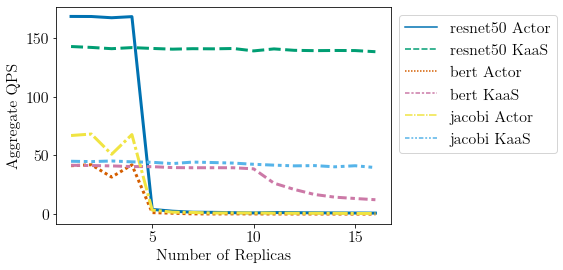

In [11]:
plot = plotThroughput(thrResults)
# plot = plotThroughput({ k: v for k, v in thrResults.items() if k in ['bert', 'jacobi']})
# plot = plotThroughput({ k: v for k, v in thrResults.items() if k in ['resnet50']})
plot.figure.savefig("figs/offlineResults.png", dpi=300, bbox_inches='tight')
# resnetPlt = plotThroughput(resnetDf)
# bertPlt = plotThroughput(bertDf)

# resnetPlt.figure.savefig("resnetOffline.png", dpi=300, bbox_inches='tight')
# bertPlt.figure.savefig("bertOffline.png", dpi=300, bbox_inches='tight')

# Microbench

In [75]:
def getLimits(pltDF):
    totalHeights = pltDf.transpose().sum()
    maxHeight = totalHeights.max()

    threshold = 0.25
    bigHeights = totalHeights[totalHeights > maxHeight * threshold]
    minBig = bigHeights.min()
    
    smallHeights = totalHeights[totalHeights < maxHeight * threshold]
    maxSmall = smallHeights.max()

    return ((0, maxSmall * 1.2), (minBig * 0.7, maxHeight * 1.2))
    
    
def plotMicroBroken(pltDF, title=''):
    limits = getLimits(pltDF)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios" : [0.5, 1]})
    
    ax1.spines['bottom'].set_visible(False)
    ax1.tick_params(axis='x',which='both',bottom=False)
    ax2.spines['top'].set_visible(False)
    
    ax2.set_ylim(limits[0][0], limits[0][1])
    ax1.set_ylim(limits[1][0], limits[1][1])
    
    pltDF.plot(kind='bar', stacked=True, ax=ax1, legend=None)
    pltDF.plot(kind='bar', stacked=True, ax=ax2, legend=None)
    
    make_hatches(ax1, pltDF)
    make_hatches(ax2, pltDF)
    
    # sets the slash on the break on the axis
    for tick in ax2.get_xticklabels():
        tick.set_rotation(0)
    d = .015  
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)      
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
    kwargs.update(transform=ax2.transAxes)  
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
    
    ax1.set_title(title)
    
    ax1.set_xlabel("")
    ax2.set_xlabel("")
    ax1.tick_params(axis='x', rotation=0)
    ax2.tick_params(axis='x', rotation=0)
    
    ax2.set_ylabel("Time (ms)")
    ax2.yaxis.set_label_coords(-0.1, 0.85)
    
    ax2.get_legend().remove()
    ax1.legend(bbox_to_anchor=[1, 0.5])
    # Skinny legend
#     ax1.legend(loc='center left', bbox_to_anchor=[1,0.5])
    # Regular readable legend off to the side
#     ax1.legend(loc='center left', bbox_to_anchor=[1,-1])
    
    return fig

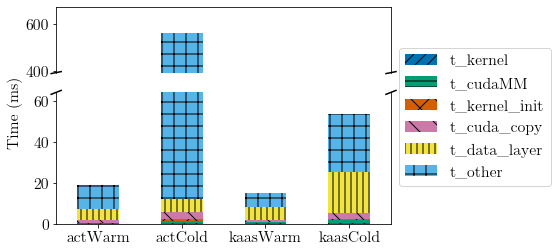

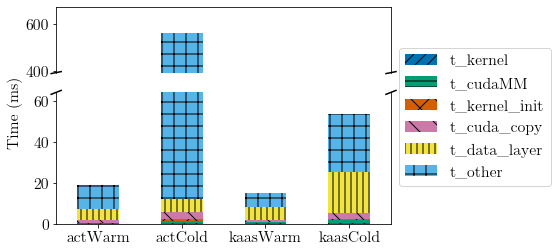

In [76]:
pltDf = microResults.drop(columns=['t_e2e'])

plotMicroBroken(pltDf)